# Base
Ich muss unterscheiden nach

- task_name = qnli, qqp, sst2
- type = vanilla_modded

In [4]:
import pandas as pd
import seaborn as sns 
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

In [5]:
df = read_wandb_csv("D_base_dataset_sizes.csv")
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'beta1', 'beta2',
       ...
       'test_f1_best_f1', 'train_loss', 'train_p_max', 'train_p_var',
       'train_st1_loss', 'train_st1_p_max', 'train_st2_loss',
       'train_st2_p_max', 'vector_norms', 'mode'],
      dtype='object', length=101)

In [6]:
import functools
import operator 

selected_rows = functools.reduce(
    operator.and_,
    [
        df["task_name"] == 'qnli',
        df["Tags"].str.contains('modded')
    ]  
)
filtered_df = df.loc[selected_rows]

In [7]:
import numpy as np

grouped_df = filtered_df.groupby(['training_size', 'insert_dropout', 'learning_rate'])

result = grouped_df['test_accuracy_best_accuracy'].agg([np.median, np.std])
result

median       std
training_size insert_dropout learning_rate                    
32            0.24           0.00001        0.648926  0.086264
              0.28           0.00001        0.649414  0.087370
64            0.24           0.00001        0.674316  0.064917
              0.28           0.00001        0.663086  0.059052
128           0.24           0.00001        0.692383  0.053295
                             0.00002        0.690918  0.055881
256           0.16           0.00002        0.726074  0.017167
              0.20           0.00002        0.724121  0.027069
512           0.16           0.00002        0.741699  0.009905
                             0.00004        0.746094  0.010380
1024          0.12           0.00006        0.785645  0.006801
              0.16           0.00006        0.785645  0.010354
2048          0.10           0.00006        0.803711  0.011138
              0.12           0.00006        0.798340  0.007927

In [8]:
# Get the index of the row with the maximum median in each group
idx = result.groupby('training_size')['median'].idxmax()

# Use the index to select the rows from the original DataFrame
best_combinations = result.loc[idx]
best_combinations

,,,median,std
training_size,insert_dropout,learning_rate,,
32,0.28,0.00001,0.649414,0.087370
64,0.24,0.00001,0.674316,0.064917
128,0.24,0.00001,0.692383,0.053295
256,0.16,0.00002,0.726074,0.017167
512,0.16,0.00004,0.746094,0.010380
1024,0.12,0.00006,0.785645,0.006801
2048,0.10,0.00006,0.803711,0.011138


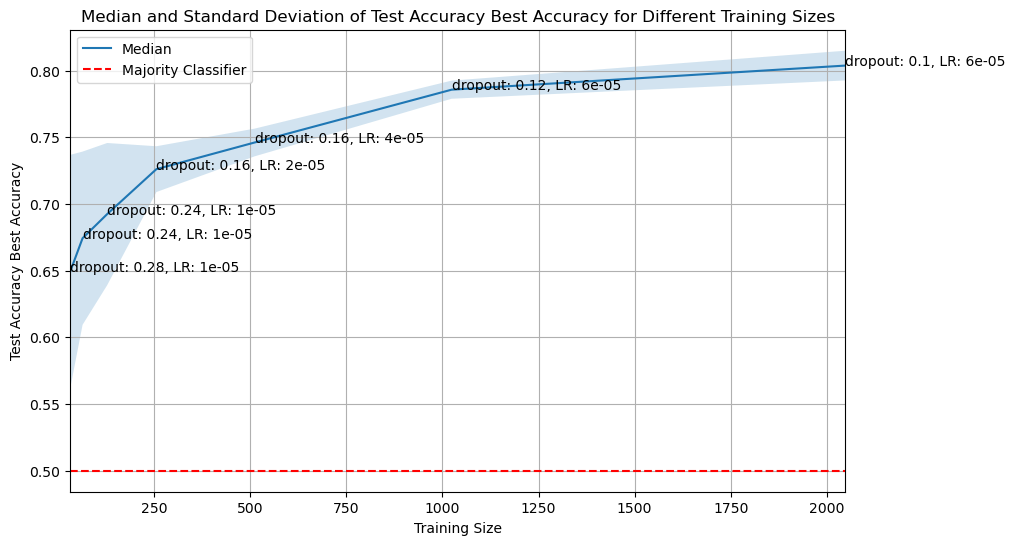

In [9]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'training_size' for proper plotting
best_combinations = best_combinations.sort_values('training_size')

# Extract values
x = best_combinations.index.get_level_values('training_size')
y = best_combinations['median']
error = best_combinations['std']

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the median line
plt.plot(x, y, label='Median')

# Fill the area between the median +/- standard deviation
plt.fill_between(x, y-error, y+error, alpha=0.2)

# Annotate the points with the 'insert_dropout' and 'learning_rate' values
for i, (idx, row) in enumerate(best_combinations.iterrows()):
    plt.annotate(f"dropout: {idx[1]}, LR: {idx[2]}", (x[i], y.iloc[i]))

y_majority_cls = 0.5
plt.axhline(y=y_majority_cls, color='r', linestyle='--', label='Majority Classifier')

# Add labels and title
plt.xlabel('Training Size')
plt.ylabel('Test Accuracy Best Accuracy')
plt.title('Median and Standard Deviation of Test Accuracy Best Accuracy for Different Training Sizes')
plt.legend()
plt.xlim(min(x), max(x))
plt.grid(True)
# Show the plot
plt.show()

Version2 

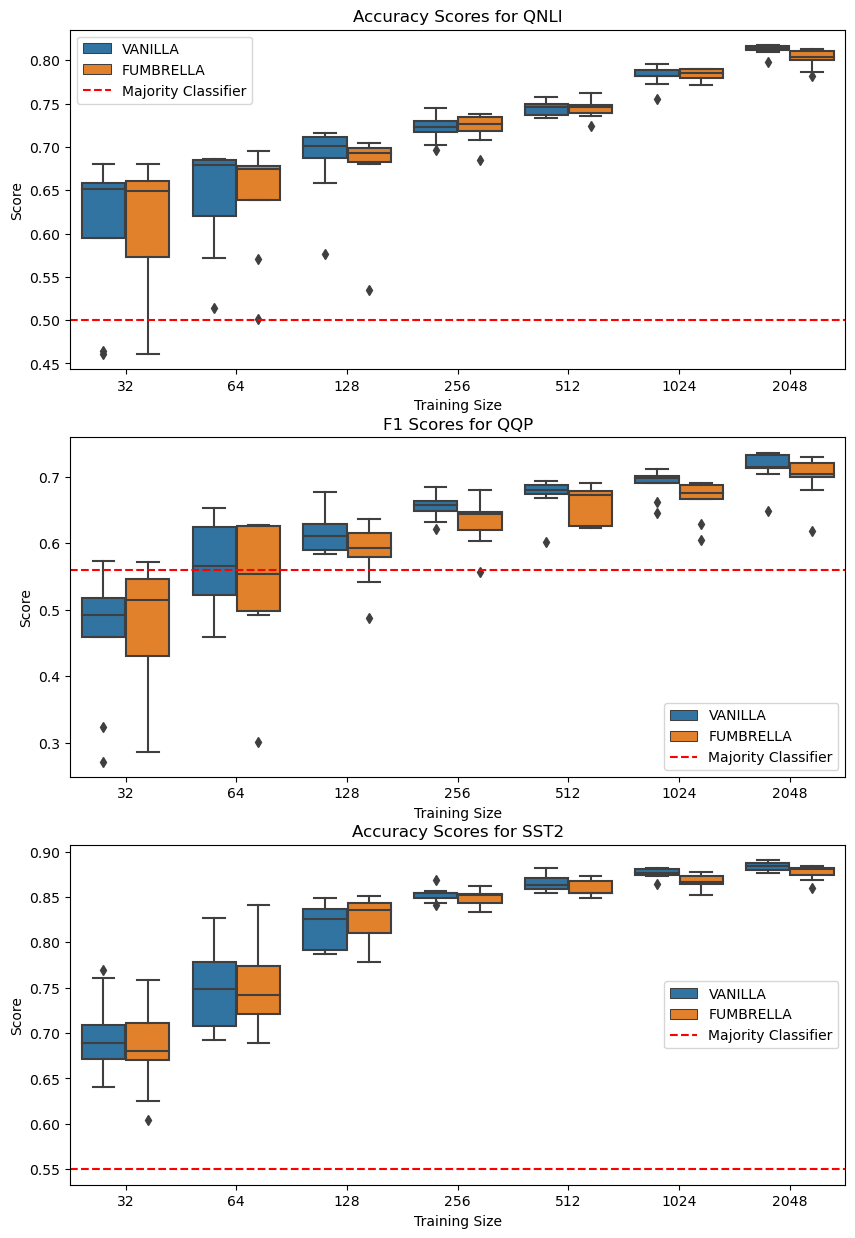

In [14]:

task_names = ['qnli','qqp','sst2']
majority_classifiers = {
    'qnli' : 0.5,
    'qqp' : 0.56, # 0.63 for acc    
    'sst2' : 0.55
}
metrics = {
    'qnli' : 'accuracy',
    'qqp' : 'f1',
    'sst2' : 'accuracy'
}
fig, axs = plt.subplots(
    len(task_names),
    1,
    figsize = (10,15),
    )

for index, task_name in enumerate(task_names):
    metric = metrics[task_name]
    metric_key = f'test_{metric}_best_accuracy'
    selected_rows = functools.reduce(
        operator.and_,
        [
            df["task_name"] == task_name,
            # df["Tags"].str.contains('modded')
        ]  
    )
    filtered_df = df.loc[selected_rows]
    grouped_df = filtered_df.groupby(['mode','training_size', 'insert_dropout', 'learning_rate'])
    medians = grouped_df[metric_key].median()
    idx = medians.groupby(['mode','training_size']).idxmax()
    best_combinations = filtered_df.loc[filtered_df.set_index(['mode','training_size', 'insert_dropout', 'learning_rate',]).index.isin(idx)]

    ax = axs[index]
    sns.boxplot(
        x='training_size',
        y=metric_key,
        hue='mode',
        data=best_combinations,
        ax = axs[index]
        )
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Score')
    ax.set_title(f'{metric.capitalize()} Scores for {task_name.upper()}')
    ax.axhline(
        y=majority_classifiers[task_name],
        color='r',
        linestyle='--',
        label='Majority Classifier'
        )
    ax.legend()
plt.savefig('D_base_dataset_sizes_boxplot.pdf', format='pdf')



In [11]:
idx

mode       training_size
FUMBRELLA  32                 (FUMBRELLA, 32, 0.28, 1e-05)
           64                 (FUMBRELLA, 64, 0.28, 1e-05)
           128               (FUMBRELLA, 128, 0.24, 2e-05)
           256               (FUMBRELLA, 256, 0.16, 2e-05)
           512               (FUMBRELLA, 512, 0.16, 2e-05)
           1024             (FUMBRELLA, 1024, 0.12, 6e-05)
           2048              (FUMBRELLA, 2048, 0.1, 6e-05)
VANILLA    32                   (VANILLA, 32, 0.28, 1e-05)
           64                   (VANILLA, 64, 0.24, 2e-05)
           128                  (VANILLA, 128, 0.2, 1e-05)
           256                 (VANILLA, 256, 0.16, 1e-05)
           512                 (VANILLA, 512, 0.16, 2e-05)
           1024               (VANILLA, 1024, 0.12, 6e-05)
           2048               (VANILLA, 2048, 0.12, 6e-05)
Name: test_accuracy_best_accuracy, dtype: object

In [12]:
medians

mode       training_size  insert_dropout  learning_rate
FUMBRELLA  32             0.24            0.00001          0.680176
                          0.28            0.00001          0.680664
           64             0.24            0.00001          0.717285
                          0.28            0.00001          0.742188
           128            0.24            0.00001          0.823242
                                          0.00002          0.835449
           256            0.16            0.00002          0.851562
                          0.20            0.00002          0.847168
           512            0.16            0.00002          0.854492
                                          0.00004          0.852051
           1024           0.12            0.00006          0.866699
                          0.16            0.00006          0.863281
           2048           0.10            0.00006          0.880859
                          0.12            0.00006          0

In [13]:
best_combinations

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,beta1,beta2,...,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms,mode
9,21_S11_ID_44_VAN,finished,-,ricu,"SWP11, vanilla",2024-01-07T11:50:59.000Z,63,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.027787,0.990442,NaN,VANILLA
10,21_S11_ID_43_VAN,finished,-,ricu,"SWP11, vanilla",2024-01-07T11:48:05.000Z,155,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001798,0.998204,NaN,VANILLA
11,21_S11_ID_42_VAN,finished,-,ricu,"SWP11, vanilla",2024-01-07T11:46:36.000Z,69,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.026612,0.991490,NaN,VANILLA
12,21_S11_ID_41_VAN,finished,-,ricu,"SWP11, vanilla",2024-01-07T11:44:49.000Z,88,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.039857,0.992578,NaN,VANILLA
13,21_S11_ID_40_VAN,finished,-,ricu,"SWP11, vanilla",2024-01-07T11:42:44.000Z,105,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004764,0.996387,NaN,VANILLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,21_S1_ID_49_VAN,finished,-,ricu,"SWP1, vanilla",2024-01-05T05:15:09.000Z,90,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005959,0.995597,NaN,VANILLA
668,21_S1_ID_48_VAN,finished,-,ricu,"SWP1, vanilla",2024-01-05T05:12:06.000Z,165,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001699,0.998305,NaN,VANILLA
670,21_S1_ID_47_VAN,finished,-,ricu,"SWP1, vanilla",2024-01-05T05:09:48.000Z,120,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001434,0.998568,NaN,VANILLA
671,21_S1_ID_46_VAN,finished,-,ricu,"SWP1, vanilla",2024-01-05T05:07:22.000Z,127,NaN,0.9,0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002221,0.997783,NaN,VANILLA
